In [1]:
# ==============================
# STEP 1: Import libraries
# ==============================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, accuracy_score, classification_report
from math import sqrt

In [3]:
# ==============================
# STEP 2: Load and prepare data
# ==============================
df = pd.read_csv("./datasets/ratnapark_pm25_after_imputation.csv")

# Drop unnecessary column
# df = df.drop(columns=['Unnamed: 0'])

In [87]:
df

,Unnamed: 0,PM2.5,YEAR,MO,DY,HR,PS,WS2M,WD2M,WS10M,WD10M,PRECTOTCORR,RH2M,QV2M,T2M,date
0,0,75.780952,2022,1,1,0,88.03,0.47,317.6,0.77,319.2,0.0,83.08,6.70,8.85,2022-01-01
1,1,56.584127,2022,1,1,1,88.00,0.40,310.0,0.64,313.7,0.0,80.28,6.48,8.86,2022-01-01
2,2,49.538710,2022,1,1,2,87.96,0.26,319.6,0.46,323.9,0.0,78.29,6.27,8.74,2022-01-01
3,3,47.398438,2022,1,1,3,87.93,0.28,300.3,0.46,306.1,0.0,77.32,6.02,8.32,2022-01-01
4,4,42.821875,2022,1,1,4,87.91,0.29,329.0,0.51,330.4,0.0,75.66,5.80,8.09,2022-01-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26299,8779,74.526667,2024,12,31,19,87.83,0.62,256.0,1.44,253.1,0.0,92.40,8.28,10.37,2024-12-31
26300,8780,84.556666,2024,12,31,20,87.85,0.44,262.2,0.92,263.7,0.0,91.04,7.94,9.97,2024-12-31
26301,8781,105.226666,2024,12,31,21,87.85,0.45,266.2,1.00,261.4,0.0,91.15,7.68,9.46,2024-12-31
26302,8782,107.503333,2024,12,31,22,87.85,0.58,279.0,1.19,274.8,0.0,89.81,7.39,9.11,2024-12-31


In [11]:
# Combine year, month, and day into a date column
df['date'] = pd.to_datetime(df.rename(columns={'YEAR': 'year', 'MO': 'month', 'DY': 'day'})[['year', 'month', 'day']])

# ==============================
# STEP 3: Identify daily peak PM2.5 (actual)
# ==============================
daily_peak = df.groupby('date').apply(lambda x: x.loc[x['PM2.5'].idxmax()])
daily_peak = daily_peak[['PM2.5', 'HR', 'PS', 'WS2M', 'WD2M', 'WS10M', 'WD10M',
                         'PRECTOTCORR', 'RH2M', 'QV2M', 'T2M']].rename(
    columns={'PM2.5': 'actual_peak', 'HR': 'actual_peak_hour'}
).reset_index()

In [12]:
daily_peak

,date,actual_peak,actual_peak_hour,PS,WS2M,WD2M,WS10M,WD10M,PRECTOTCORR,RH2M,QV2M,T2M
0,2022-01-01,117.401562,9,88.15,0.98,232.4,1.29,232.9,0.0,58.95,6.61,13.84
1,2022-01-02,84.952381,9,88.02,1.06,222.7,1.42,222.7,0.0,52.90,5.81,13.51
2,2022-01-03,85.859375,9,87.86,1.23,243.4,1.63,243.4,0.0,54.86,6.03,13.49
3,2022-01-04,95.376562,9,87.90,1.00,236.0,1.32,236.4,0.0,48.03,5.33,13.65
4,2022-01-05,58.518182,9,87.93,0.83,195.4,1.02,197.0,0.0,68.48,7.03,12.45
...,...,...,...,...,...,...,...,...,...,...,...,...
1091,2024-12-27,122.165000,21,88.11,0.57,81.9,0.89,78.9,0.0,75.80,7.16,11.22
1092,2024-12-28,171.928334,18,87.91,0.45,281.6,0.92,275.0,0.0,77.62,7.97,12.44
1093,2024-12-29,159.361667,1,87.90,0.66,351.3,0.99,348.9,0.0,66.54,6.31,11.25
1094,2024-12-30,128.735001,0,87.73,0.76,305.4,1.25,304.2,0.0,78.93,7.49,11.22


In [15]:
# ==============================
# STEP 4: Prepare features and target for regression (peak value)
# ==============================
X_reg = daily_peak[['PS', 'WS2M', 'WD2M', 'WS10M', 'WD10M',
                    'PRECTOTCORR', 'RH2M', 'QV2M', 'T2M']]
y_reg = daily_peak['actual_peak']

X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X_reg, y_reg, test_size=0.2, random_state=42
)

In [23]:
# ==============================
# STEP 5: Train regression model
# ==============================
reg_model = RandomForestRegressor(n_estimators=300, random_state=42)
reg_model.fit(X_train_reg, y_train_reg)


RandomForestRegressor(n_estimators=300, random_state=42)

In [24]:
# Predict on test set
y_pred_reg = reg_model.predict(X_test_reg)

In [25]:
y_test_reg

44      17.054790
568     19.500000
56      17.054790
636     34.400000
486     87.900000
          ...    
757    147.385000
713     56.100000
365     78.006897
299     28.605852
286     27.707692
Name: actual_peak, Length: 220, dtype: float64

In [26]:
y_pred_reg

array([ 98.89427358,  26.7403113 , 103.27671496,  28.76692565,
        61.93924587,  99.79363394, 138.29465782,  95.93756824,
       133.24055921,  62.96234139,  24.2050276 ,  26.00038304,
        32.24396784, 124.85176387,  48.93017412,  51.01312848,
        22.8346774 ,  62.95202685,  90.97059272, 116.68397201,
        26.18392371,  28.83084725,  74.73979533, 119.85764526,
       109.73604206,  22.44703402,  54.22525507,  88.92215008,
        59.21680378, 107.1562925 ,  88.24427151,  97.24212888,
        87.10566185,  26.49342859,  56.24538648, 121.93031627,
        44.6079433 , 125.03351731,  98.33928623,  62.25772195,
       119.41040747,  30.4592818 ,  55.14925411,  71.67188726,
        85.68799282,  85.82572484,  82.17330751, 127.73467424,
        25.54976675,  25.13971443,  51.95393001,  22.26274867,
        25.86832093,  24.17759143,  27.85030869,  33.96462843,
        29.73282427,  83.30581792,  61.7497979 , 119.26674908,
        78.20834235,  92.2366018 ,  78.86459183,  68.49

In [27]:
# Evaluation
mae = mean_absolute_error(y_test_reg, y_pred_reg)
rmse = sqrt(mean_squared_error(y_test_reg, y_pred_reg))
r2 = r2_score(y_test_reg, y_pred_reg)

print("🔹 Regression Model Performance:")
print(f"MAE: {mae:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"R²: {r2:.3f}\n")


🔹 Regression Model Performance:
MAE: 21.437
RMSE: 32.074
R²: 0.527



In [28]:
# ==============================
# STEP 6: Classification (predicting peak hour)
# ==============================
X_cls = daily_peak[['PS', 'WS2M', 'WD2M', 'WS10M', 'WD10M',
                    'PRECTOTCORR', 'RH2M', 'QV2M', 'T2M']]
y_cls = daily_peak['actual_peak_hour']

X_train_cls, X_test_cls, y_train_cls, y_test_cls = train_test_split(
    X_cls, y_cls, test_size=0.2, random_state=42
)

clf_model = RandomForestClassifier(n_estimators=150, random_state=42)
clf_model.fit(X_train_cls, y_train_cls)
y_pred_cls = clf_model.predict(X_test_cls)

# Classification metrics
acc = accuracy_score(y_test_cls, y_pred_cls)
print("🔹 Classification Model Performance:")
print(f"Accuracy: {acc:.3f}")
print("\nClassification Report:\n", classification_report(y_test_cls, y_pred_cls))

🔹 Classification Model Performance:
Accuracy: 0.423

Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        12
           2       0.00      0.00      0.00         4
           4       0.00      0.00      0.00         2
           5       0.33      0.50      0.40         2
           6       0.24      0.33      0.28        12
           7       0.44      0.60      0.51        30
           8       0.56      0.72      0.63        46
           9       0.68      0.68      0.68        37
          10       0.40      0.33      0.36         6
          11       0.40      0.40      0.40         5
          12       0.00      0.00      0.00         1
          13       0.00      0.00      0.00         1
          16       0.00      0.00      0.00         1
          18       0.00      0.00      0.00         6
          19       0.13      0.22      0.17         9
          20       0.00      0.00      0.00         9
    

C:\Users\thhnp\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\thhnp\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\thhnp\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [67]:
y_df_test= y_test_cls.to_frame().reset_index()
# y_df_test = y_df_test['actual_peak_hour']
y_df_test   

,index,actual_peak_hour
0,44,8
1,568,7
2,56,8
3,636,21
4,486,20
...,...,...
215,757,8
216,713,9
217,365,9
218,299,7


In [66]:
y_val =[]
for i in y_pred_cls:
    y_val.append(i)

y_val_df = pd.DataFrame(y_val)
y_val_df
    

,0
0,8
1,8
2,8
3,19
4,7
...,...
215,8
216,9
217,9
218,20


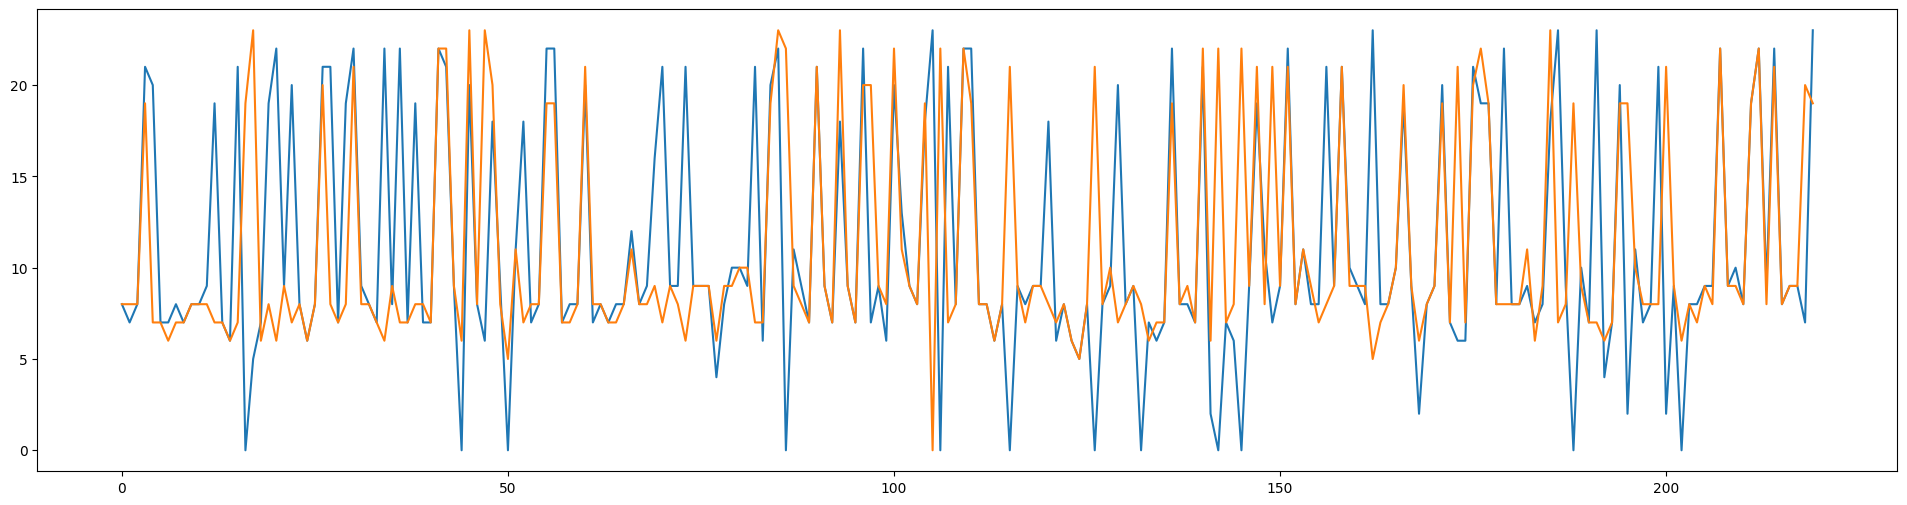

In [75]:
plt.figure(figsize=(24, 6))
# plt.plot(y_pred_cls)
plt.plot(y_df_test['actual_peak_hour'])
plt.plot(y_val_df)
plt.show()

In [85]:
# ==============================
# STEP 7: Create results DataFrame
# ==============================

# 1️⃣ Create results for regression (peak value prediction)
results_df = daily_peak.loc[y_test_reg.index, ['date', 'actual_peak', 'actual_peak_hour']].copy()
results_df['predicted_peak'] = y_pred_reg
results_df.to_csv('result.csv')


In [86]:
plot_df = pd.read_csv('result.csv')
plot_df

,date,date.1,actual_peak,actual_peak_hour,predicted_peak
0,2022-02-14,2022-02-14,17.054790,8,98.894274
1,2023-07-23,2023-07-23,19.500000,7,26.740311
2,2022-02-26,2022-02-26,17.054790,8,103.276715
3,2023-09-29,2023-09-29,34.400000,21,28.766926
4,2023-05-02,2023-05-02,87.900000,20,61.939246
...,...,...,...,...,...
215,2024-01-28,2024-01-28,147.385000,8,131.227541
216,2023-12-15,2023-12-15,56.100000,9,109.195492
217,2023-01-01,2023-01-01,78.006897,9,71.195802
218,2022-10-27,2022-10-27,28.605852,7,66.078174


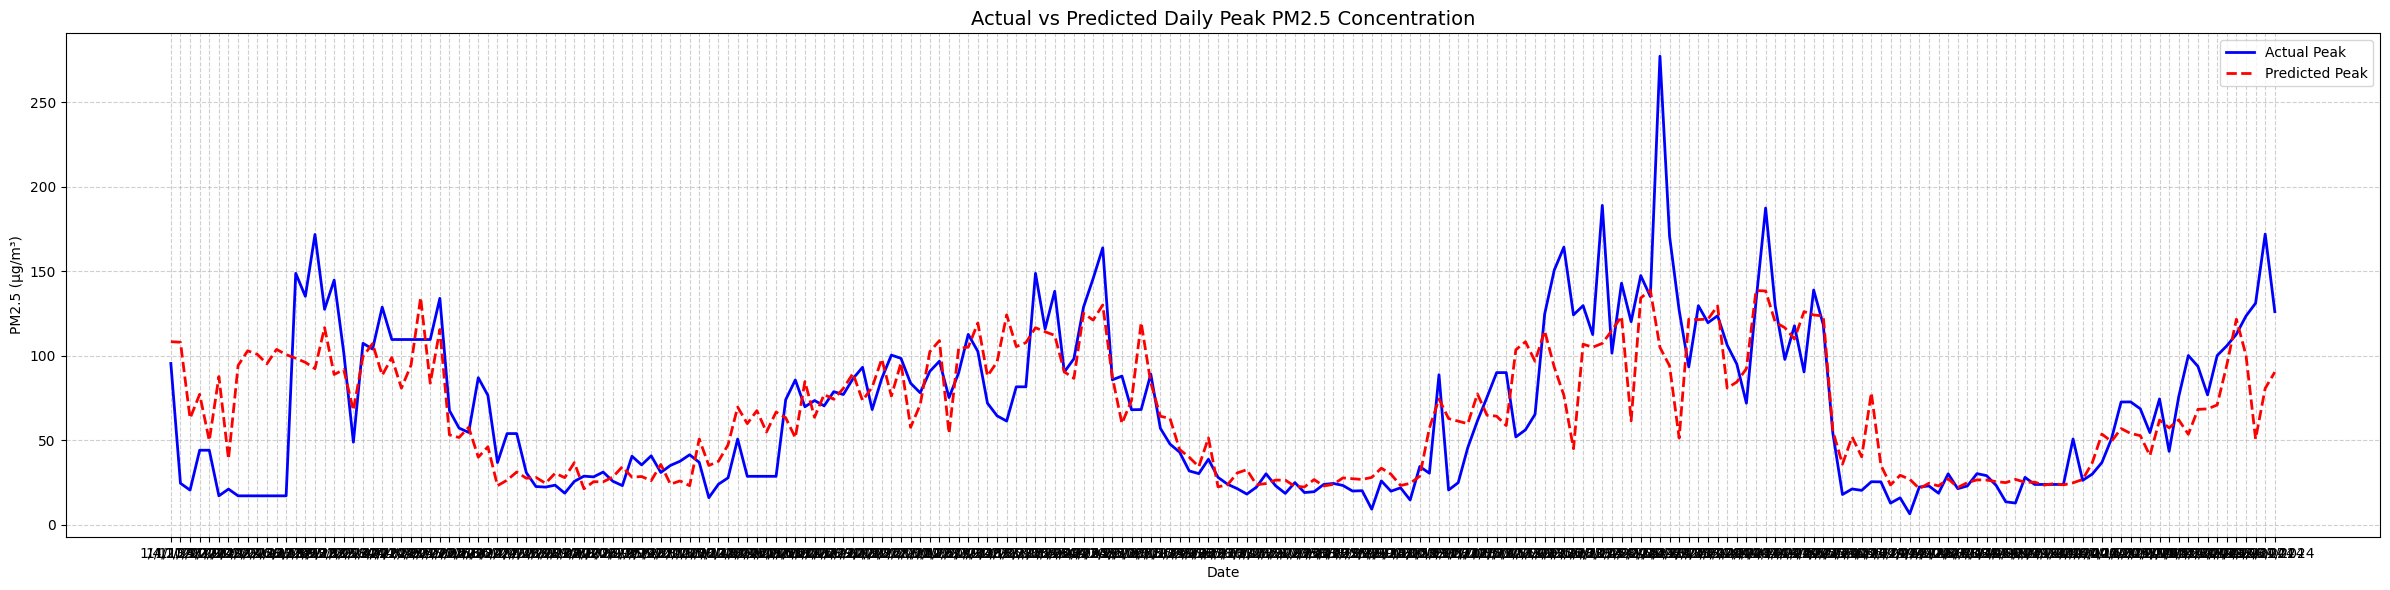

In [61]:

# Plot actual vs predicted peaks
plt.figure(figsize=(24, 6))
plt.plot(plot_df['date'], plot_df['actual_peak'], label='Actual Peak', color='blue', linewidth=2)
plt.plot(plot_df['date'], plot_df['predicted_peak'], label='Predicted Peak', color='red', linestyle='--', linewidth=2)
plt.title('Actual vs Predicted Daily Peak PM2.5 Concentration', fontsize=14)
plt.xlabel('Date')
plt.ylabel('PM2.5 (µg/m³)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

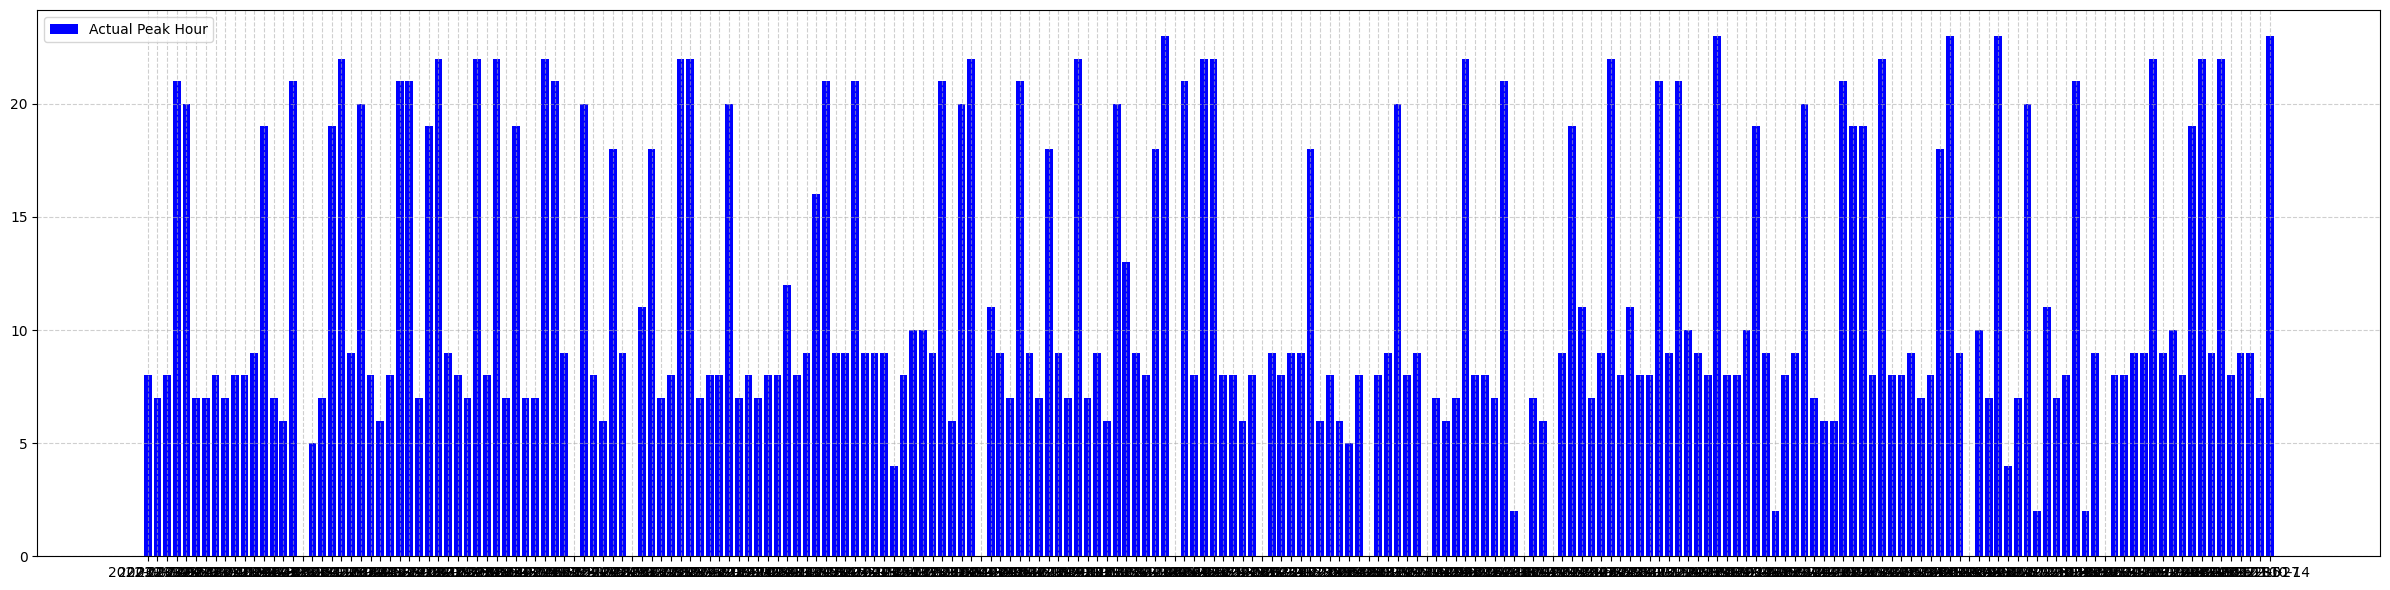

In [91]:
# Plot actual vs predicted peaks
plt.figure(figsize=(24, 6))
plt.bar(plot_df['date'], plot_df['actual_peak_hour'], label='Actual Peak Hour', color='blue', linewidth=2)
# plt.title('Actual vs Predicted Daily Peak PM2.5 Concentration', fontsize=14)
# plt.xlabel('Date')
# plt.ylabel('PM2.5 (µg/m³)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [93]:
plot_df['actual_peak_hour'].nunique()

19

In [116]:
# category_summary = df.groupby(["Category"])["Amount"].sum().reset_index() 

peak_hours_counts = plot_df.groupby(['actual_peak_hour'])['date'].count().reset_index()
peak_hours_counts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19 entries, 0 to 18
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   actual_peak_hour  19 non-null     int64
 1   date              19 non-null     int64
dtypes: int64(2)
memory usage: 436.0 bytes


C:\Users\thhnp\AppData\Local\Temp\ipykernel_16552\903257165.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


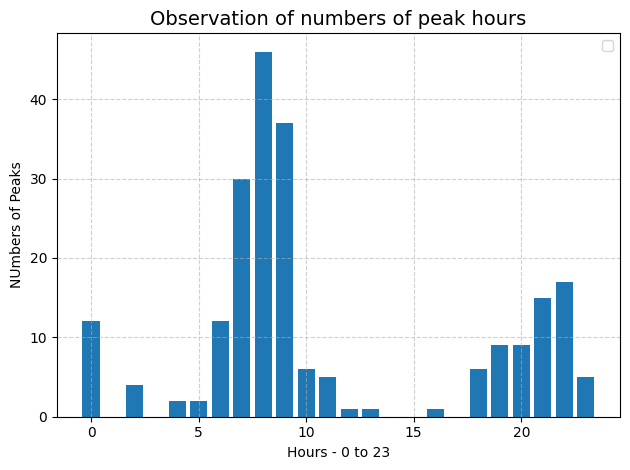

In [118]:
# plt.figure(figsize=(10, 8))
# plt.bar(plot_df['date'], plot_df['actual_peak_hour'], label='Actual Peak Hour', color='blue', linewidth=2)
plt.bar( peak_hours_counts['actual_peak_hour'], peak_hours_counts['date'])
plt.title('Observation of numbers of peak hours', fontsize=14)
plt.xlabel('Hours - 0 to 23')
plt.ylabel('NUmbers of Peaks')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()